Filtern

Wir bearbeiten das Thema zum "used Cars Dataset" zur vohrersage von Gerbrauchtwagenpreisen basierend auf den Dataset, dass online von "kaggle.com". Unsere Ziel besteht darin, dass Dataset zu "bereinigen" um nur noch für die Preisvorhersage relevante Daten zuverwenden um eine möglichst schnelle jedoch trotzdem noch präzise Aussage zu den Preisen der Fahrzeuge zu erhalten.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans

Als erster wir die CSV Datei importiert und als Dataframe abgelegt.

In [51]:
url = 'C:/Users/oache/Desktop/KI_ML/vehicles/vehicles.csv'
#url= 'C:/Users/nicof/OneDrive/Dokumente/FH-München/KI\Modularbeit/archive/vehicles.csv'
df = pd.read_csv(url)


Als nächstes lassen wir uns die ersten fünf Einträge anzeigen, um einen Überblick über die Daten zu erlangen. Es fällt auf, dass einige der Spalten für die Vorhersage des Preises nicht von nutzen sein werden.

In [52]:
df.head(5)


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


Um einen Überblick zu bekommen mit wievielen Daten wir uns beschäftigen lassen wir uns die Dimensionen des Dataframes anzeigen. Wir haben ein Datenfeld in der größe 426880 x 26

In [53]:
df.shape

(426880, 26)

Um eine Überblick über die Fahrzeughersteller und deren Inseratanteilen zu bekommen lassen wir uns dies anhande der Stückzahlen anzeigen.

<BarContainer object of 42 artists>

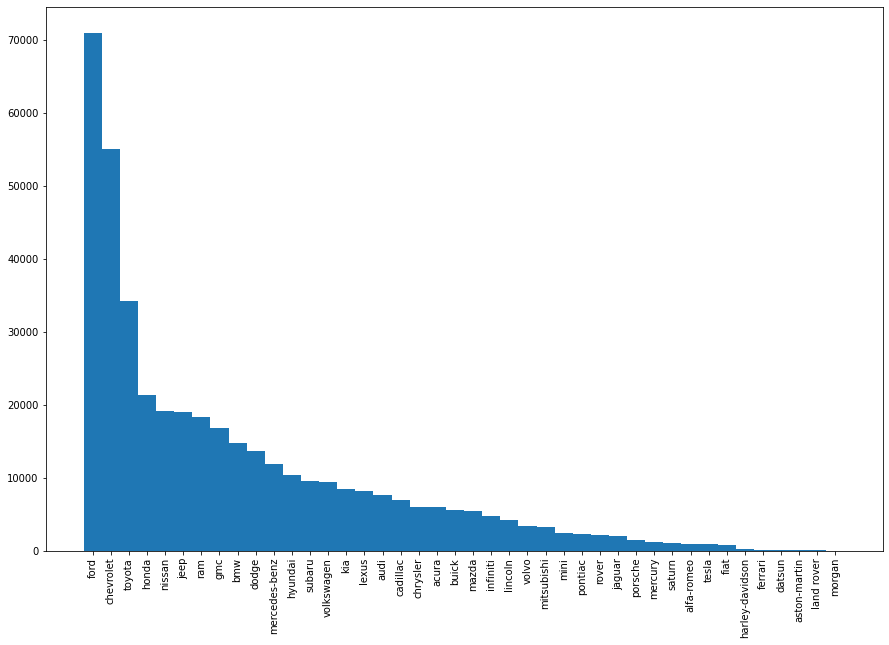

In [54]:
x = (df.groupby(['manufacturer'],as_index = False).count().sort_values('price', ascending = False))['manufacturer'].tolist()
y = (df.groupby(['manufacturer'],as_index = False).count().sort_values('price', ascending = False))['price'].tolist()
fig = plt.figure(figsize=(15,10))
plt.xticks(rotation = 90)
plt.bar(x, y, width=1)

Wir lassen uns die unterschiedlichen Angaben zu den jeweiligen Kategorien anzeigen.

In [55]:
print(df["paint_color"].unique())
print(df["condition"].unique())
print(df["type"].unique())
print(df["fuel"].unique())
print(df["cylinders"].unique())
print(df["title_status"].unique())
print(df["type"].unique())
print(df["drive"].unique())
print(df["transmission"].unique())

[nan 'white' 'blue' 'red' 'black' 'silver' 'grey' 'brown' 'yellow'
 'orange' 'green' 'custom' 'purple']
[nan 'good' 'excellent' 'fair' 'like new' 'new' 'salvage']
[nan 'pickup' 'truck' 'other' 'coupe' 'SUV' 'hatchback' 'mini-van' 'sedan'
 'offroad' 'bus' 'van' 'convertible' 'wagon']
[nan 'gas' 'other' 'diesel' 'hybrid' 'electric']
[nan '8 cylinders' '6 cylinders' '4 cylinders' '5 cylinders' 'other'
 '3 cylinders' '10 cylinders' '12 cylinders']
[nan 'clean' 'rebuilt' 'lien' 'salvage' 'missing' 'parts only']
[nan 'pickup' 'truck' 'other' 'coupe' 'SUV' 'hatchback' 'mini-van' 'sedan'
 'offroad' 'bus' 'van' 'convertible' 'wagon']
[nan 'rwd' '4wd' 'fwd']
[nan 'other' 'automatic' 'manual']


Um einen Überblick zu erhalten, wie oft in der jeweiligen Kategorie kein Eintrag vorhanden ist lassen wir uns dies Anzeigen.

In [56]:
df.isnull().sum().sort_values(ascending = False)

county          426880
size            306361
cylinders       177678
condition       174104
VIN             161042
drive           130567
paint_color     130203
type             92858
manufacturer     17646
title_status      8242
lat               6549
long              6549
model             5277
odometer          4400
fuel              3013
transmission      2556
year              1205
description         70
image_url           68
posting_date        68
url                  0
price                0
state                0
region_url           0
region               0
id                   0
dtype: int64

Um die Vorhersage des Preises präziser zu ermöglichen, entfernen wir die Spalten aus dem Dataframe die wir für unnötige erachten:
- county: extrem hohe Anzahl ein Nan einträgen.
- size: extrem hohe Anzahl ein Nan einträgen.
- id, url, region_url, lat, long, vin, image_url, description, geometry: Diese Angaben sind teilweise sehr individuell (z.B. description), oder für eine Preisvorhersage nicht relevant.
- size: Die "größe" des Fahrzeugs ist Modellabhängig und kann somit ebenfalls entfernt werden.
- region: Diese Angabe ist sehr präzise wir nutzen die Angaben in der Kategorie 'state' zur örtlichen Einschränkung.

In [57]:


df.drop([ 'id', 'url', 'region_url', 'lat', 'long', 'VIN', 'image_url',
         'description', 'county','size','region'], axis = 1, inplace = True)
df.head(5)

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date
0,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN
1,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN
2,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN
3,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN
4,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN


In der Kategorie "title_status" sind die Angaben [nan 'clean' 'rebuilt' 'lien' 'salvage' 'missing' 'parts only'] vorhanden.(siehe oben) Für eine Preisvorhersage von Fahrzeugen, können die Inserate mit dem Titel 'rebuilt' 'lien' 'salvage' 'missing' 'parts only' jedoch nicht verwendet werden, weshalb title_status als gesamte Spalte gedropt werden kann. 

In [58]:

df.drop('title_status',axis=1, inplace= True)


Aussortieren von Inseraten mit unrealistischen Preisen

In [59]:
df = df[((df['price'] < 500000) & (df['price'] > 100))]

Jetzt lassen wir uns die Fahrzeuginserate anhand der Baujahre und des zugehörigen Preises anzeigen.

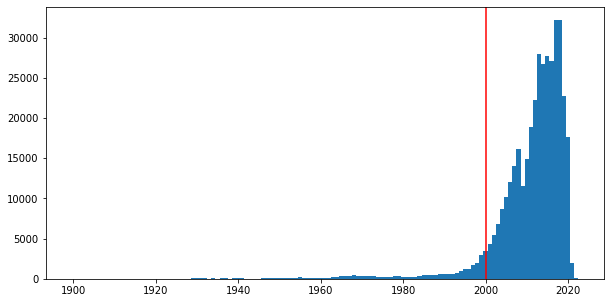

In [60]:
starting_year = 2000
x = (df.groupby(['year'],as_index = False).count())['year'].tolist()
y = (df.groupby(['year'],as_index = False).count())['price'].tolist()
fig = plt.figure(figsize=(10,5))
plt.bar(x, y, width=1)
plt.axvline(starting_year, color = 'red')

Die Anzahl an Fahrzeugen die vor 2000 gebaut wurden ist sehr gering und die Preise niedrig, für diese Fahrzeuge ist keine genau Preis Ermittlung möglich.

In [61]:

df = df[df['year'] > starting_year]


Fahrzeuge mit sehr hohen Tachostand (höchsten 5%) können ebenfalls ignoriert werden.

In [62]:
top5 = np.nanpercentile(df['odometer'], 95)
df = df[df['odometer'] < top5]

Fahrzeuge die keine Angeben in den Spalten fuel, transmission, manufacturer und model können ebenfalls vernächlässigt werden, da diese Angaben hohe Priorität haben.

In [63]:
df.dropna(subset = ['fuel', 'transmission'], axis = 0, inplace = True)
df = df[~df['manufacturer'].isnull()]
df = df[~df['model'].isnull()]
df.shape

(324875, 14)

Um im späteren Verlauf eine Prediction zu ermöglichen ersetzen wir in den restlichen Spalten die Nan Angaben durch unknowen bzw. not specified

In [64]:
df['condition'].fillna('not specified', inplace = True)
df['paint_color'].fillna('unknown', inplace = True)


Da in einigen inseraten Modell verschieden beschrieben werden z.B. F150, F150 good condition, F-150 beschränken wir uns auf das erste Wort in der Beschreibung und entfernen alle Modelle die anschließend weniger als 150 mal auftreten. Desweitern fügen wir den manufacturer in der Spalte model hinzu, um zu vermeiden, dass Fahrzeuge die den gleichen Modellnamen jedoch von unterschiedlichen Herstellern sind, zusammengfügt werden. Dies machen wir in einem speraten Dataframe um uns die Unterschiede anzeigen lassen zu können

In [65]:


model_list = df['model'].tolist()
model_list = map(str, model_list)
model_list = [x.lower().strip() for x in model_list]
my_list = [car_model.split()[0] for car_model in model_list]
my_list = [x.replace(' ', '').replace('-', '').replace('/', '') for x in my_list]

df['car_model'] = my_list
df['car_model'] = df['manufacturer'] + "_" + df['car_model']

new_car_models = (df.groupby(['car_model'], as_index= False).count())[['manufacturer', 'car_model', 'price']]
new_car_models = new_car_models.rename(columns={'price': 'count'})
only_common_models = new_car_models[new_car_models['count'] > 250]

print('Alle models ', len(new_car_models['count']))
print('models mit mehr als 150 Einträgen: ', len(only_common_models['count']))
print('Prozentualeranteil an gelöschten models:', round((1-len(only_common_models['count'])/len(new_car_models['count'])) * 100, 2))
print()
print('Gesamtanzahl an Inseraten: ', len(df['price']))
print('Verbleibende Inserate: ', sum(only_common_models['count']))
print('Prozentualeranteil an gelöschten Inseraten ', round((1-sum(only_common_models['count'])/len(df['price'])) * 100, 2))

Alle models  2062
models mit mehr als 150 Einträgen:  227
Prozentualeranteil an gelöschten models: 88.99

Gesamtanzahl an Inseraten:  324875
Verbleibende Inserate:  286356
Prozentualeranteil an gelöschten Inseraten  11.86


Um einen graphischen Überblick zu erhalten wieviele Fahrzeugemodell und Inserate gelöscht werden, wenn wir die mindest Anzahl auf 250 setzen lassen wir uns dies Anzeigen.

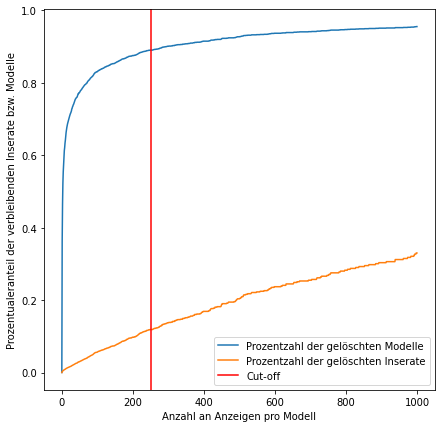

In [66]:
removed_models_list = []
removed_instances_list = []

for i in range(0,1000):
    only_common_models_v2 = new_car_models[new_car_models['count']>i]
    models_removed = 1-len(only_common_models_v2['count'])/len(new_car_models['count'])
    instances_removed = 1-sum(only_common_models_v2['count'])/len(df['price'])
    
    removed_models_list.append(models_removed)
    removed_instances_list.append(instances_removed)

fig = plt.figure(figsize=(7,7))
plt.plot(removed_models_list, label = 'Prozentzahl der gelöschten Modelle')
plt.plot(removed_instances_list, label = 'Prozentzahl der gelöschten Inserate')
plt.axvline(250 , color = 'red', label = 'Cut-off')
plt.ylabel('Prozentualeranteil der verbleibenden Inserate bzw. Modelle')
plt.xlabel('Anzahl an Anzeigen pro Modell')
plt.legend()

Wir sind mit unsere Grenze von min. 250 Fahrzeugen zufrieden, da noch genügend Daten für eine Preisvorhersage vorhanden sind und trotzdem stark genüg reduziert wurde um die Gefahr des overfittings zu veringern. 
Wir übernehmen unsere Änderungen im Hauptdataframe. Durch das zusammenfügen von manufacturer und model können wir die beiden Spalten ebenfalls dropen.

In [67]:
df = df[df['car_model'].isin(only_common_models['car_model'].tolist())]
df.drop('model', axis = 1, inplace = True)
df.drop('manufacturer',axis = 1, inplace= True)


In [68]:
df.head(5)

,price,year,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state,posting_date,car_model
27,33590,2014.0,good,8 cylinders,gas,57923.0,other,NaN,pickup,white,al,2021-05-04T12:31:18-0500,gmc_sierra
28,22590,2010.0,good,8 cylinders,gas,71229.0,other,NaN,pickup,blue,al,2021-05-04T12:31:08-0500,chevrolet_silverado
29,39590,2020.0,good,8 cylinders,gas,19160.0,other,NaN,pickup,red,al,2021-05-04T12:31:25-0500,chevrolet_silverado
30,30990,2017.0,good,8 cylinders,gas,41124.0,other,NaN,pickup,red,al,2021-05-04T10:41:31-0500,toyota_tundra
31,15000,2013.0,excellent,6 cylinders,gas,128000.0,automatic,rwd,truck,black,al,2021-05-03T14:02:03-0500,ford_f150


Wir lassen uns das aktuelle Datafield anzeigen um einen Überblick zubekommen.

In [69]:
df.iloc[:,11]

27        2021-05-04T12:31:18-0500
28        2021-05-04T12:31:08-0500
29        2021-05-04T12:31:25-0500
30        2021-05-04T10:41:31-0500
31        2021-05-03T14:02:03-0500
                    ...           
426875    2021-04-04T03:21:31-0600
426876    2021-04-04T03:21:29-0600
426877    2021-04-04T03:21:17-0600
426878    2021-04-04T03:21:11-0600
426879    2021-04-04T03:21:07-0600
Name: posting_date, Length: 286356, dtype: object

In [70]:
i=0
for x in df.posting_date:
     df.iloc[i,11]=x[:7:]
     i=i+1

df
print(df["posting_date"].unique())


['2021-05' '2021-04']


Da alle Inserate innerhalb der letzten zwei Monaten angeboten wurden können wir die Splate 'posting_date' ebenfalls entfernen.

In [71]:
df=df.drop('posting_date',axis=1)
df.head()

,price,year,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state,car_model
27,33590,2014.0,good,8 cylinders,gas,57923.0,other,NaN,pickup,white,al,gmc_sierra
28,22590,2010.0,good,8 cylinders,gas,71229.0,other,NaN,pickup,blue,al,chevrolet_silverado
29,39590,2020.0,good,8 cylinders,gas,19160.0,other,NaN,pickup,red,al,chevrolet_silverado
30,30990,2017.0,good,8 cylinders,gas,41124.0,other,NaN,pickup,red,al,toyota_tundra
31,15000,2013.0,excellent,6 cylinders,gas,128000.0,automatic,rwd,truck,black,al,ford_f150


In der Splate cylinders ersetzen wir die Werte Nan durch den Median und löschen die Einträge mit der Angabe 'others'.

In [72]:
df = df[df['cylinders'] != 'other']
dftest = df.copy()
test = df[df['cylinders'].notnull()].copy()
test['cylinders'] = [int(cyl.split()[0]) for cyl in test['cylinders']]
med = test.groupby('car_model')['cylinders'].median()
merged = pd.merge(dftest, med, on = 'car_model', how = 'left')
merged['cylinders_y'].fillna(med.median(), inplace = True)
merged['cylinders_x'].fillna(merged['cylinders_y'], inplace = True)

li = []
for cyl in merged['cylinders_x']:
    if type(cyl) == str:
        li.append(cyl)
    else:
        li.append(str(int(cyl)) + " cylinders")

df['cylinders'] = li


Wir fügen in der Spalte "drive" bei Einträgen ohne Anagbe den am häuigst auftretenden Werte ein.

In [73]:
dftest = df.copy()
test = df[df['drive'].notnull()].copy()
mode = test.groupby('car_model')['drive'].agg(pd.Series.mode)
merged = pd.merge(dftest, mode, on = 'car_model', how = 'left')
merged['drive_x'].fillna(merged['drive_y'], inplace = True)

df['drive'] = merged['drive_x'].tolist()

Selbiges führen wir für die Spalte "type" druch.

In [74]:
dftest = df.copy()
test = df[df['type'].notnull()].copy()
mode = test.groupby('car_model')['type'].agg(pd.Series.mode)
merged = pd.merge(dftest, mode, on = 'car_model', how = 'left')
merged['type_x'].fillna(merged['type_y'], inplace = True)

df['type'] = merged['type_x'].tolist()


Um zu überprüfen, ob keine weiteren Nan einträge in den Spalten vorhanden sind zählen wir die Einträge mit Nan in allen Kategorien

In [75]:
df.isnull().sum()

price           0
year            0
condition       0
cylinders       0
fuel            0
odometer        0
transmission    0
drive           0
type            0
paint_color     0
state           0
car_model       0
dtype: int64

Einträge die einen untypisch hohen Preis (dreifcher Durchschnittspreis) haben, entfernen wir ebenfalls aus dem Datensatz.

In [76]:
df = df[df['price'] < (3 * df.groupby('car_model')['price'].transform('mean'))]

Um eine Vorstellung zu bekommen wieviele Einträge und Spalten wir durch unsere Eingrenzungsmaßnahemn entferen konnten lassen wir uns erneut die Dimensionen des Dataframes anzeigen. Wir konnten von einem die Einträge im Dataframe von 426880 x 26 auf 284827 x 12 reduzieren.

In [77]:
df.shape

(284827, 12)

In [78]:
df.head()

,price,year,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state,car_model
27,33590,2014.0,good,8 cylinders,gas,57923.0,other,4wd,pickup,white,al,gmc_sierra
28,22590,2010.0,good,8 cylinders,gas,71229.0,other,4wd,pickup,blue,al,chevrolet_silverado
29,39590,2020.0,good,8 cylinders,gas,19160.0,other,4wd,pickup,red,al,chevrolet_silverado
30,30990,2017.0,good,8 cylinders,gas,41124.0,other,4wd,pickup,red,al,toyota_tundra
31,15000,2013.0,excellent,6 cylinders,gas,128000.0,automatic,rwd,truck,black,al,ford_f150


Wir erstellen eine Kopie des Dataframes um es erneut herstellen zukönnen. Und erstellen die csv Datei clean.

In [79]:
clean = df.copy()

In [80]:
df.to_csv('clean.csv', index = False)

Wir trennen für unsere späteren Modelle unsere Daten nun in Testdaten und Trainingsdaten, wobei 80% der Daten für das Training verwenden, da wir diesen Wert häufig online gefunden werden. Damit das auftrennen der Daten nicht immer neu programmiert werden müssen, haben wir dies hier in eine Schleife gemacht. Innerhalb dieser haben wir die Daten dann noch zur Fehlervermeidung und um die Performance (für Modelle wie Linear Regression, K-nearest neighbors or support vector machines)zu verbessern mit StandardScalar standartisiert. 
Am Ende lassen wir uns dann noch die Abweichungen beziehungsweise die Genauigkeit der Vorhersagen sowohl der Trainingsdaten, als auch der Testdaten Anzeigen.
"Mae" ist dabei der absolute Fehler, "mse" der quadratische Fehler und "mape" der absolute Fehler in Prozent. r^2 sagt uns dabei zusätzlich, wie gut unsere Vorhersage die wirklichen Daten wiederspiegelt. Des weiteren lassen wir uns den Betrag der Abweichung in Prozent zu den jeweiligen Fahrzeug Modellen anzeigen. Ebenfalls wir die häufigkeit der Fahrzeuge als auch die aufsummierte prozentuale Abweichung angezeigt.

In [153]:

def updateModel(df, test_percentage = 0.2, seed = 7):
    
   
    X = df.drop('price', axis = 1)
    y = df['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_percentage, random_state = seed)
    X_train = pd.get_dummies(X_train, drop_first = True)
    X_test = pd.get_dummies(X_test, drop_first = True)
    
   
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
  
    reg.fit(X_train, y_train)
    y_pred_test = reg.predict(X_test)
    y_pred_train = reg.predict(X_train)
   
   
    if 'car_model' in X.columns:
       diff=pd.DataFrame(round(((y_pred_test/y_test)-1)*100,2))
       X['diff in %']=diff     
       X_clean=X[X['diff in %'].notna()] 
       X_clean=pd.DataFrame(X_clean)
       predicted=X_clean
       predicted['price']=y_test
       X_clean=X_clean.reset_index()
       X_clean=X_clean.drop('index',axis=1)
       result=pd.DataFrame(X_clean['car_model'].unique())
       result[1]=0
       result[2]=0
       z=0
       count1=0
       count2=0
     

       for p in X_clean['car_model']:
              for k in result[0]:
                     if p in k:
                            result.loc[count2,1]=result.loc[count2,1]+ X_clean.loc[count1,'diff in %']
                            result.loc[count2,2]=result.loc[count2,2]+1
                     count2=count2+1
              count2=0
              count1=count1+1  
                     
       result[3]=result[1]/result[2]
       result[3]=abs(result[3])
       result=result.sort_values(3)
       result.columns = ['car_model','sum %', 'amount','absolute deviation ']
       print(result)

    
   
   
    test_metrics = {#'r2': round(r2_score(y_test, y_pred_test) * 100, 2),
           'mae': round(mean_absolute_error(y_test, y_pred_test), 2),
           #'mse': round(mean_squared_error(y_test, y_pred_test), 2),
           'mape': round(mean_absolute_percentage_error(y_test, y_pred_test) * 100, 2)
           }
    train_metrics = {#'r2': round(r2_score(y_train, y_pred_train) * 100, 2),
           'mae': round(mean_absolute_error(y_train, y_pred_train), 2),
           #'mse': round(mean_squared_error(y_train, y_pred_train), 2),
           'mape': round(mean_absolute_percentage_error(y_train, y_pred_train) * 100, 2)
           }
    
    return {'test_metrics': test_metrics,
            'train_metrics': train_metrics,
            'predicted': predicted,
            }
            
            

Damit unsere Daten innerhalb eines Modells nicht zu einseitig trainiert werden, zum Beispiel nur auf günstigen oder nur auf teuren Autos, splitten wir die gesamten Daten in fünf "Gruppen" auf, aus denen wir unsere Testdaten und unsere  Trainingsdaten in unserer Funktion (ein Feld oben drüber) dann trainieren.

In [82]:
def get_kCVscores(datafr, k = 5, scoring = 'neg_mean_absolute_error'):
    X = datafr.drop('price', axis = 1)
    X = pd.get_dummies(X, drop_first = True)
    y = datafr['price']
    return (cross_val_score(reg, X, y, cv = k, scoring = scoring) * (-1))

Mit K-Means Clustern wir unsere Daten. K-Means hat den Vorteil,dass es die Daten relativ schnell clustert, solange diese nicht zu komplex sind. Dies ist hier der Fall. 

In [83]:
def k_means_clustering(datafr, k):
    df_to_return = datafr.copy()
    df_with_dummies = pd.get_dummies(datafr, drop_first = True)
    km = KMeans(n_clusters = k)
    df_to_return['cluster'] = km.fit_predict(df_with_dummies)
    
    return df_to_return

Die lineare Regression ist ein einfaches Modell, weswegen es auch nur eine sehr kurze Rechenzeit benötigt. Dafür hat es im gegenzug teilweise auch relativ große Abweichungen bei seiner Vorhersage (mae= 4494.54).[1]

In [84]:
reg = LinearRegression()

In [170]:
init_metrics = updateModel(df)
def print_metrics(metrics):
    print('test performance:', metrics['test_metrics'])    
    print('initial test performance:', init_metrics['test_metrics'])
    print()
    print('train performance:', metrics['train_metrics'])
    print('initial train performance:', init_metrics['train_metrics'])
    print()
    print('change in test MAE:', round((init_metrics['test_metrics']['mae'] - metrics['test_metrics']['mae']) / 
      (init_metrics['test_metrics']['mae']) * 100, 2), '%')
print_metrics(init_metrics)
prediction=(init_metrics['predicted'])

             car_model      sum %  amount  absolute deviation 
211     volkswagen_gti      -1.92      61             0.031475
47        infiniti_q60      -4.40      62             0.070968
116       cadillac_xts     -11.20      50             0.224000
13        jaguar_epace     -44.25      83             0.533133
88           subaru_xv     -39.61      59             0.671356
..                 ...        ...     ...                  ...
154       cadillac_xt5   41843.50      71           589.345070
199        rover_sport   44335.48      68           651.992353
207   volkswagen_atlas   67285.74      72           934.524167
148  volkswagen_tiguan  147399.21     154           957.137727
167      dodge_charger  411576.52     380          1083.096105

[227 rows x 4 columns]
test performance: {'mae': 4494.54, 'mape': 178.22}
initial test performance: {'mae': 4494.54, 'mape': 178.22}

train performance: {'mae': 4481.22, 'mape': 174.43}
initial train performance: {'mae': 4481.22, 'mape': 174.4

In [175]:
prediction=pd.DataFrame(prediction)
good = prediction[(prediction['car_model'] == 'infiniti_q60')]
good=good.reset_index()
good=good.drop('index',axis=1)
good=good.sort_values('price')
max_diff=max(good['price'])-min(good['price'])
diff_prc=max(good['price'])/min(good['price'])*100  
print(good)   
print('Die Differenz zwischen maximalen und minimalen Preis liegt bei:', max_diff)
print('Der prozentuale Unterschied zwischen maximalen und minimalen Preis liegt bei:', diff_prc)

      year      condition    cylinders   fuel  odometer transmission drive  \
38  2017.0           good  6 cylinders    gas   40022.0    automatic   rwd   
23  2017.0           good  6 cylinders  other   33011.0        other   rwd   
61  2017.0           good  6 cylinders    gas   67004.0        other   rwd   
1   2017.0           good  6 cylinders    gas   67004.0        other   rwd   
2   2017.0           good  6 cylinders    gas   67004.0        other   rwd   
..     ...            ...          ...    ...       ...          ...   ...   
40  2019.0           good  6 cylinders    gas   13785.0        other   rwd   
52  2019.0           good  6 cylinders    gas    7396.0        other   rwd   
54  2019.0           good  6 cylinders    gas    7396.0        other   rwd   
30  2019.0           good  6 cylinders    gas    7396.0        other   rwd   
22  2019.0  not specified  6 cylinders    gas   15461.0    automatic   rwd   

     type paint_color state     car_model  diff in %  price  
3

In [174]:
prediction=pd.DataFrame(prediction)
bad = prediction[(prediction['car_model'] == 'dodge_charger')]
bad=bad.reset_index()
bad=bad.drop('index',axis=1)
bad=bad.sort_values('price')
max_diff=max(bad['price'])-min(bad['price']) 
diff_prc=max(bad['price'])/min(bad['price'])*100 
print(bad)   
print('Die Differenz zwischen maximalen und minimalen Preis liegt bei:', max_diff)
print('Der prozentuale Unterschied zwischen maximalen und minimalen Preis liegt bei:', diff_prc)

       year      condition    cylinders   fuel  odometer transmission drive  \
288  2013.0  not specified  6 cylinders    gas  164463.0    automatic   4wd   
0    2017.0  not specified  6 cylinders    gas   20120.0    automatic   rwd   
282  2017.0  not specified  6 cylinders    gas   21347.0    automatic   rwd   
73   2017.0  not specified  6 cylinders    gas   21088.0    automatic   rwd   
277  2017.0  not specified  6 cylinders    gas   21933.0    automatic   rwd   
..      ...            ...          ...    ...       ...          ...   ...   
227  2018.0           good  6 cylinders  other   12281.0        other   rwd   
285  2016.0      excellent  8 cylinders    gas   19886.0    automatic   rwd   
116  2019.0  not specified  6 cylinders    gas   11898.0    automatic   rwd   
299  2020.0           good  8 cylinders    gas    2175.0    automatic   rwd   
359  2020.0  not specified  6 cylinders    gas    1413.0    automatic   rwd   

      type paint_color state      car_model  diff i

Nun werden die Staaten durch ihre jeweilige Region, wie Westen,Süden,Südwesten und soweiter ersetzt und in einem Dataframe gespeichert. 

In [ ]:
regions_dict = {"state": ["al","ak","az","ar","ca","co","ct","de","dc","fl","ga","hi","id","il","in","ia","ks","ky","la","me","md","ma","mi","mn","ms","mo","mt","ne","nv","nh","nj","nm","ny","nc","nd","oh","ok","or","pa","ri","sc","sd","tn","tx","ut","vt","va","wa","wv","wi","wy"], 
         "region": ["south","west","west","south","west","west","north-east","south","south","south","south","west","west","mid-west","mid-west","mid-west","mid-west","south","south","north-east","south","north-east","mid-west","mid-west","south","mid-west","west","mid-west","west","north-east","north-east","west","north-east","south","mid-west","mid-west","south","west","north-east","north-east","south","mid-west","south","south","west","north-east","south","west","south","mid-west","west"]}
dfState = pd.merge(df, pd.DataFrame(regions_dict), on = 'state', how = 'left').drop('state', axis = 1)
dfState

Mit dem auf Regionen veränderten Dataframe testen wir nur erneut die Performance.

In [ ]:
binned_states_metrics = updateModel(dfState)
print_metrics(binned_states_metrics)

Da der Einfluss ob die Region oder der Staat im Dataframe ist, sehr klein (-0.08%) ist, kann dieser im weiteren vorgehen wahrscheinlich vernachlässigt werden. Um diese Hypothese zu überprüfen, erstellen wir den Dataframe ohne state.

In [ ]:
dfDropState = df.drop('state', axis = 1)
dfDropState

Mit diesen Dataframe wird erneut das Modell getestet und der Einfluss ist mit -0,69% wirklich sehr gering.

In [ ]:
drop_state_metrics = updateModel(dfDropState)
print_metrics(drop_state_metrics)

In [ ]:
dfNoCarModel = df.drop('car_model', axis = 1)
dfNoCarModel

Als nächstes lassen wir das Fahrzeugmodell weg um die größe des Einflusses zu testen. Hierbei können wir eine Verschlechterung von 17.11% feststellen.

In [ ]:
no_car_model_metrics = updateModel(dfNoCarModel)
print_metrics(no_car_model_metrics)

Als nächstes wird der Einfluss vom Car_model ähnlich dem vom state getestet. Nur dieses mal wird direkt die Spalte car_model gedroppt und in einen Dataframe gespeichert.

In [ ]:
dfAge = df.copy()
dfAge['age'] = [2022 - x for x in df['year'].tolist()]
dfAge.drop('year', axis=1, inplace = True)
dfAge

Anhand einer Grafik lässt sich bis zu einem gewissen Alter ein abfallender Preis feststellen. Dies lässt sich dadurch erklären, dass zum einen Oldtimer wieder im Wert steigen und zum anderen die Preise soweit gesunken sind, sodass der Wertverlust keinen großen Einfluss mehr hat.

In [ ]:
dfAgeCat = dfAge.copy()
thresholds = [20,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1]
groups = ['over 20','15-20','14','13','12','11','10','9','8','7','6','5','4','3','2','1']

x = (dfAgeCat.groupby(['age'],as_index = False).mean())['age'].tolist()
y = (dfAgeCat.groupby(['age'],as_index = False).mean())['price'].tolist()
fig = plt.figure(figsize=[10,5])
plt.ylabel('Mean price')
plt.xlabel('Age (years)')
plt.bar(x, y, width=1)
for t in thresholds:
    plt.axvline(t-0.5, color = 'red')

plt.axvline(-0.5, color = 'red')
plt.axvline(21.5, color = 'red')

Die Fahrzeuge werden nun nach ihrem Alter in Gruppen eingeteilt und der neue Dataframe wird dann auf seine Performance getestet.

In [ ]:
arr = np.array(dfAgeCat['age'].tolist())
for t in thresholds:
    prevArr = arr
    arr = np.where(prevArr >= t, -t, prevArr)
    
prevArr = arr
dfAgeCat['age_group'] = np.where(prevArr >= 0, 'new', prevArr).tolist()

for i in range(len(thresholds)):
     toReplace = str(float(-thresholds[i]))
     dfAgeCat['age_group'].replace(toReplace, groups[i], inplace =  True)

dfAgeCat.drop('age', axis=1, inplace=True)    
print(dfAgeCat['age_group'].unique())
dfAgeCat

In [ ]:
age_cat_metrics = updateModel(dfAgeCat)
print_metrics(age_cat_metrics)

Mit der nachfolgenden Schleife wird der Einfluss der restlichen Spalten auf den Preis grafisch dargestellt.

In [ ]:
dfPlots = dfAge.copy()
for feat in dfAgeCat.drop(['price','odometer','car_model','age_group'], axis = 1).columns:
    print(feat)
    x = (dfPlots.groupby(feat, as_index = False).mean()).sort_values(by = ['price'])[feat]
    y = (dfPlots.groupby(feat, as_index = False).mean()).sort_values(by = ['price'])['price']
    fig = plt.figure(figsize=[10,5])
    plt.xlabel(feat)
    plt.ylabel('Mean price')
    plt.xticks(rotation = 90)
    plt.bar(x, y, width=1)
    plt.show()

Die Gruppe good und not specified werden in einer Gruppe zusammengefasst und den anderen Integerwerte als neuen Namen für das Model zugeordnet.
Mit dem daraus resultierenden Dataframe wird wieder der Einfluss auf das Model getestet.

In [ ]:
dfCondition = df.copy()

dfCondition['condition'].replace('new', 6, inplace =  True)
dfCondition['condition'].replace('like new', 5, inplace =  True)
dfCondition['condition'].replace('excellent', 4, inplace =  True)
dfCondition['condition'].replace('good', 3, inplace =  True)
dfCondition['condition'].replace('fair', 2, inplace =  True)
dfCondition['condition'].replace('salvage', 1, inplace =  True)
dfCondition['condition'].replace('not specified', 3, inplace =  True)
dfCondition['condition'].unique()

In [ ]:
condition_metrics = updateModel(dfCondition)
print_metrics(condition_metrics)

Als nächstes soll der Einfluss der Zylinder auf die Preise getestet werden.

In [ ]:
dfNoCyl = df.drop('cylinders', axis = 1)
dfNoCyl

In [ ]:
no_cyl_metrics = updateModel(dfNoCyl)
print_metrics(no_cyl_metrics)

Als nächstes soll der Einfluss des Fahrzeugtyps auf die Preise getestet werden.

In [ ]:
dfNoType = df.drop('type', axis = 1)
dfNoType

In [ ]:
no_type_metrics = updateModel(dfNoType)
print_metrics(no_type_metrics)

Aus den Tests ergab sich, dass nur das zusammenfassen nach Alter einen positiven Einfluss auf das Model hatte.

In [ ]:
df = dfAgeCat

Mit dem upgedateten Dataframe wird nun erneut die lineare Regression getestet.

In [ ]:
reg = LinearRegression()
initLR = updateModel(df)
print_metrics(initLR)

Als nächstes werden Ensemble Methoden betrachtet. Bei Ensemble Methoden werden einfache Modelle
kombiniert, um eine gute Vorhersagegenauigkeit und eine hohe Robustheit zu erhalten. Vorerst werden nur
eine kleine Anzahl an Estimator und maximaler Tiefe eingestellt. Somit können die Trainingszeiten gering
gehalten werden.
Betrachtet wird der RandomForestClassifier. Den Random_state setzen wir fest, damit dieser auch bei mehrfacher durchführung reproduzierbar ist.[2]

In [ ]:
reg = RandomForestRegressor(n_estimators = 20, random_state = 42)
initRF = updateModel(df)
print_metrics(initRF)

Um ein repräsentativeres Ergebnis zu erhalten und das Model zuverlässiger zu machen, unterteilen wir die Daten in  fünf (Standartwert) unterschiedliche kleinere Datenpakete, auf denen wir das Model testen.

In [ ]:
kcv = get_kCVscores(df)
kcv
print('Cross validated MAE mean:', kcv.mean())
print('Cross validated MAE standard deviation:', kcv.std())

Zum Vergleich wird nun der RandomForestRegressor mit mehr Verzweigungen getestet und angezeigt. 

In [ ]:
reg = RandomForestRegressor(n_estimators = 100, random_state = 42)
init100RF = updateModel(df)
print_metrics(init100RF)

Betrachtet wird ein Classifier der mit Neuronalen Netzen arbeitet. Neuronale Netze können nichtlineare Modelle
und Modelle in Echtzeit lernen. Zunächst wird ein ungeclustertes Datenset trainiert.[3]

In [ ]:
reg = MLPRegressor()
initNN = updateModel(df)
print_metrics(initNN)

Mithilfe von K_means soll nun der Datensatz einmal in die wichtigsten zwei bzw. drei wichtigsten cluster eingeteilt werden.

In [ ]:
df_clustering_k2 = k_means_clustering(df, 2)
df_clustering_k2

In [ ]:
df_clustering_k3 = k_means_clustering(df, 3)
df_clustering_k3

In [ ]:
df_to_use = pd.get_dummies(df_clustering_k2, drop_first = True)
k = 2
print('For k = ', k)

list_of_results = []
for i in range(k):
    cluster_df = (df_to_use[df_to_use['cluster']==i]).copy()
    res = updateModel(cluster_df)
    print_metrics(res)
    list_of_results.append(res)

clust_k2_LR_results = list_of_results

In [ ]:
df_to_use = pd.get_dummies(df_clustering_k3, drop_first = True)
k = 3
print('For k = ', k)

list_of_results = []
for i in range(k):
    cluster_df = (df_to_use[df_to_use['cluster']==i]).copy()
    res = updateModel(cluster_df)
    print_metrics(res)
    list_of_results.append(res)

clust_k3_LR_results = list_of_results

Das Clustern mit zwei Klassen liefert die besseren Ergebnisse. 

Zum Vergleich wird auch der RandomForestRegressor mit zwei Clustern getestet.

In [ ]:
reg = RandomForestRegressor(n_estimators = 20, random_state = 42)

In [ ]:
df_to_use = pd.get_dummies(df_clustering_k2, drop_first = True)
k = 2
print('For k = ', k)

list_of_results = []
for i in range(k):
    cluster_df = (df_to_use[df_to_use['cluster']==i]).copy()
    res = updateModel(cluster_df)
    print_metrics(res)
    list_of_results.append(res)

clust_k2_RF_results = list_of_results

In [ ]:
print_metrics(initRF)

Mithilfe der Clusterung konnte das Ergebnis des RFR weiter optimiert werden und liefert so mit die bester Vorhersage. Wir bilden das Finale CSV und Model.

In [ ]:
dfFinal = df_clustering_k2.copy()
dfFinal

In [ ]:
finalPerformance = clust_k2_RF_results
print('Cluster 1:')
print_metrics(finalPerformance[0])
print()
print('Cluster 2:')
print_metrics(finalPerformance[1])

In [ ]:
finalModel = reg
reg

In [ ]:
dfFinal.to_csv('final')

Fazit: Abschlißend lässt sich zusammenfassen: -Die lineare Regression ist mit abstand das schnellste
Verfahren, hat jedoch teilweise seher hohe Abweichungen vom tastächlichen Preis (faktor 10) -Die
Regressoren MLP und RFR haben ähnliche Testergebnisse geliefert und sind zeitlich auch ähnlich.
Der RFR ist jedoch etwas präziser weshalb wir uns für diesen entschieden haben.

Literaturverzeichnis:
Kaggle, URL https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data Abrufdatum 11.04.2022, Datensatz
[1] Sklearn lineare Regression, URL  https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html, 12.06.2022
[2] Sklearn RandomForestRegressor https://scikit-learn.org/stable/modules/ensemble.html#ensemble, 05.07.2022
[3] Sklearn MLP Regressor https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html, 23.08.2022
